In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

import frame_whitening as fw
import frame_whitening.data as fwd
import frame_whitening.simulation as fws

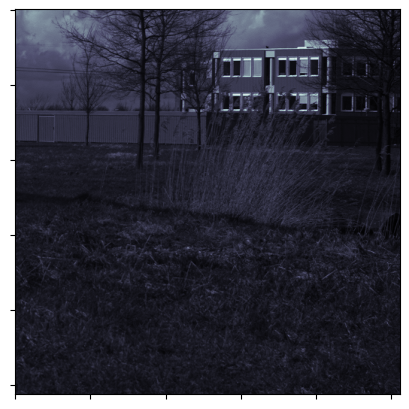

In [2]:
data_dir = "/mnt/home/tyerxa/ceph/datasets/datasets/vanhateren_imc"
files = sorted(os.listdir(data_dir))
seed = 420
rng = np.random.default_rng(seed)

n_images = 10
images = fwd.load_images(n_images=n_images, crop_size=512, rng=rng)

images = [img / np.max(img) for img in images]

img = images[4]

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.imshow(img, cmap="bone")
ax.set(xticklabels=[], yticklabels=[]);

(-0.5, 511.5, 511.5, -0.5)

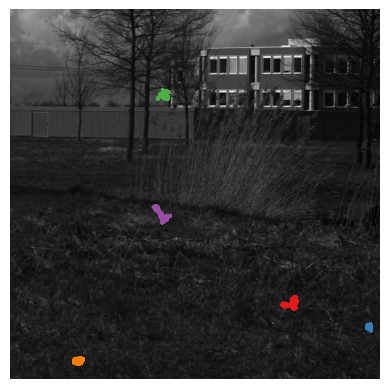

In [3]:
patch_h, patch_w = 12, 12
img_h, img_w = img.shape

sigma = .1
n_steps = 20_000

fig, ax = plt.subplots(1, 1)
im = ax.imshow(img, cmap="gray")
# plt.colorbar(im)

n_contexts = 5
cols = sns.color_palette("Set1", n_contexts)

all_contexts, walk_coords = fwd.get_contexts(img, patch_h, patch_w, n_contexts, sigma, n_steps, pad_factor=1, rng=rng)
for idx, walk_hw in enumerate(walk_coords):
    walk_h, walk_w = walk_hw[:, 0], walk_hw[:, 1]
    ax.plot(walk_h, walk_w, color=cols[idx])
ax.axis("off")

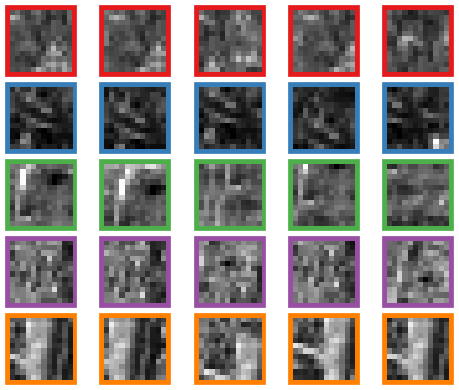

In [4]:
fwd.plot_context_samples(all_contexts, 5, "gray", "Set1", True);

In [179]:
# fwd.plot_patch_stats(all_contexts[-1])

In [5]:
X = all_contexts[0]
X0 = X.reshape(n_steps, -1)
X0 = X0 - np.mean(X0, axis=0)
X0 = X0 * 16

Cxx0 = np.cov(X0.T)
Cxx = Cxx0 + np.eye(Cxx0.shape[0]) * 1e-4

ll, V = np.linalg.eigh(Cxx)
l12 = 1/np.sqrt(ll)

Mw = V @ np.diag(l12) @ V.T

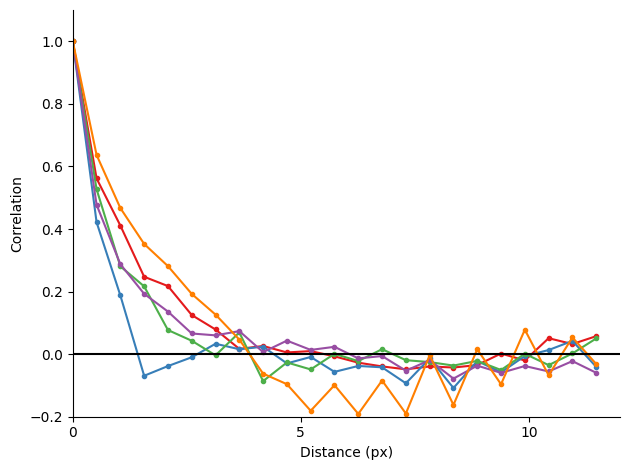

In [6]:
def get_corr_by_dist(X):
    arr = []

    # correlation matrix of X0
    corr0 = np.corrcoef(X.T)

    for i in range(Cxx0.shape[0]):
        for j in range(i, Cxx0.shape[1]):
            id_i = np.unravel_index(i, (patch_h, patch_w))
            id_j = np.unravel_index(j, (patch_h, patch_w))
            distance = np.linalg.norm(np.array(id_i) - np.array(id_j))
            corr = corr0[i, j]
            arr.append((distance, corr))

    dist = np.array(arr)
    return dist

import pandas as pd
import scipy.stats

cols = sns.color_palette("Set1", n_contexts)
fig, ax = plt.subplots(1, 1)
for ctx in range(len(all_contexts)):
    X = all_contexts[ctx]
    X0 = X.reshape(n_steps, -1)
    X0 = X0 - np.mean(X0, axis=0)
    arr = get_corr_by_dist(X0)

    yyy = scipy.stats.binned_statistic(arr[:, 0], arr[:, 1], bins=np.linspace(0, patch_h, 2*patch_h), statistic="mean")
    ax.plot(yyy.bin_edges[:-1], yyy.statistic, ".-", color=cols[ctx])

ax.hlines(0, 0, patch_h, "k")
ax.set(xlim=(0, patch_h), ylim=(-.2, 1.1), xticks=np.arange(0, patch_h+1, 5),
xlabel="Distance (px)", ylabel="Correlation")
sns.despine()
fig.tight_layout()

(144, 2664)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12288/12288 [03:10<00:00, 64.66it/s]


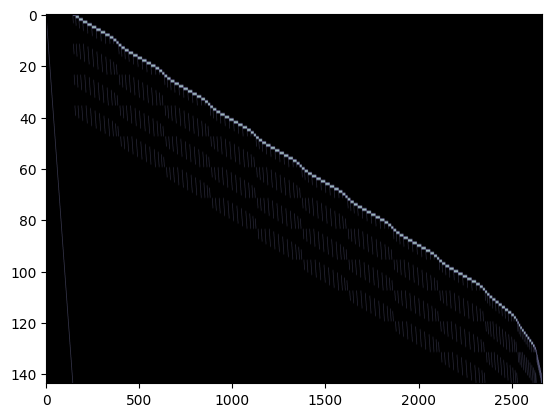

In [7]:
X = all_contexts[0]
X0 = X.reshape(n_steps, -1)
X0 = X0 - np.mean(X0, axis=0)
X0 = X0 * 16
Cxx0 = np.cov(X0.T)
Cxx = Cxx0 + np.eye(Cxx0.shape[0]) * 1e-4

n_batch = 2**11
conv_h, conv_w = 4, 4
W = fw.get_conv_frame(patch_h, patch_w, conv_h, conv_w)
print(W.shape)
plt.imshow(W, cmap="bone", aspect="auto")
step_skip = 100
# g_last_clamp, g_all_clamp, _, _ = fws.adapt_covariance(
#                                         Cxx_list=[Cxx], 
#                                         W=W, 
#                                         batch_size=-1, 
#                                         n_batch=n_batch, 
#                                         lr_g=2E-2,
#                                         g0=None, 
#                                         online=False, 
#                                         clamp=True,
#                                         alpha=1.,
#                                         save_every=step_skip,
#                                     )

g_last, g_all, _, _ = fws.adapt_covariance(
                                Cxx_list=[Cxx], 
                                W=W, 
                                batch_size=-1, 
                                n_batch=6*n_batch, 
                                lr_g=3E-3,
                                g0=None, 
                                online=False, 
                                clamp=False,
                                alpha=1.,
                                save_every=step_skip,
                            )

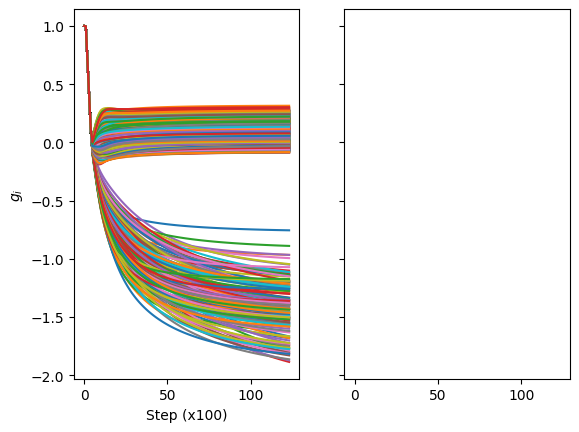

In [8]:
fig, ax = plt.subplots(1, 2, sharex="all", sharey="all")
ax[0].plot(g_all)
# ax[1].plot(g_all_clamp)

ax[0].set(xlabel=f"Step (x{step_skip})", ylabel=r"$g_i$");

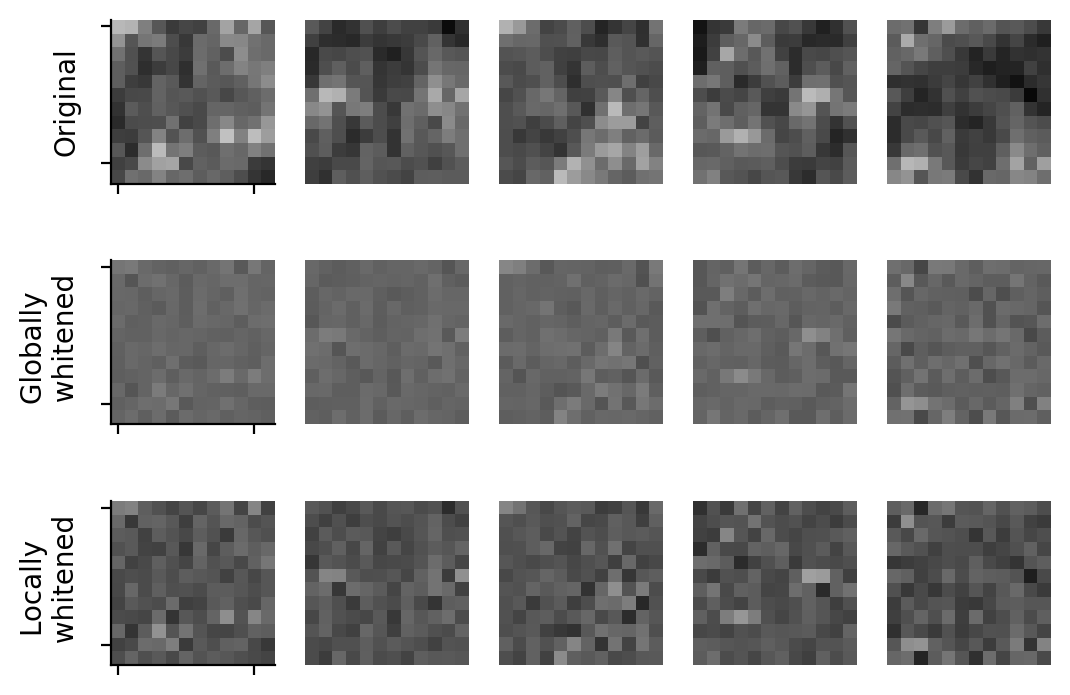

In [9]:
WGW = W @ (g_last[0][:,None] * W.T)
Ixx = np.eye(patch_h * patch_w)
M = np.linalg.inv(Ixx + WGW)
Xw_local = X0 @ M.T

# WGW_clamp = W @ (g_last_clamp[0][:,None] * W.T)
# Ixx = np.eye(patch_h * patch_w)
# M_clamp = np.linalg.inv(Ixx + WGW_clamp)
# Xw_clamp = X0 @ M_clamp.T

Xw = X0 @ Mw.T

X00 = X0.reshape(n_steps, patch_h, patch_w)
Xw = Xw.reshape(n_steps, patch_h, patch_w)
Xw_local = Xw_local.reshape(n_steps, patch_h, patch_w)
# Xw_clamp = Xw_clamp.reshape(n_steps, patch_h, patch_w)

fig, ax = fwd.plot_context_samples(np.stack([X00, Xw, Xw_local], 0), 5, "gray", "Set1", False, dpi=200)
ax[0,0].axis("on")
ax[1,0].axis("on")
ax[2,0].axis("on")
# ax[3,0].axis("on")

ax[0,0].set(xticklabels=[], yticklabels=[], ylabel="Original")
ax[1,0].set(xticklabels=[], yticklabels=[], ylabel="Globally \n whitened")
ax[2,0].set(xticklabels=[], yticklabels=[], ylabel="Locally \n whitened")
# ax[3,0].set(xticklabels=[], yticklabels=[], ylabel="Locally \n adapted")
sns.despine()

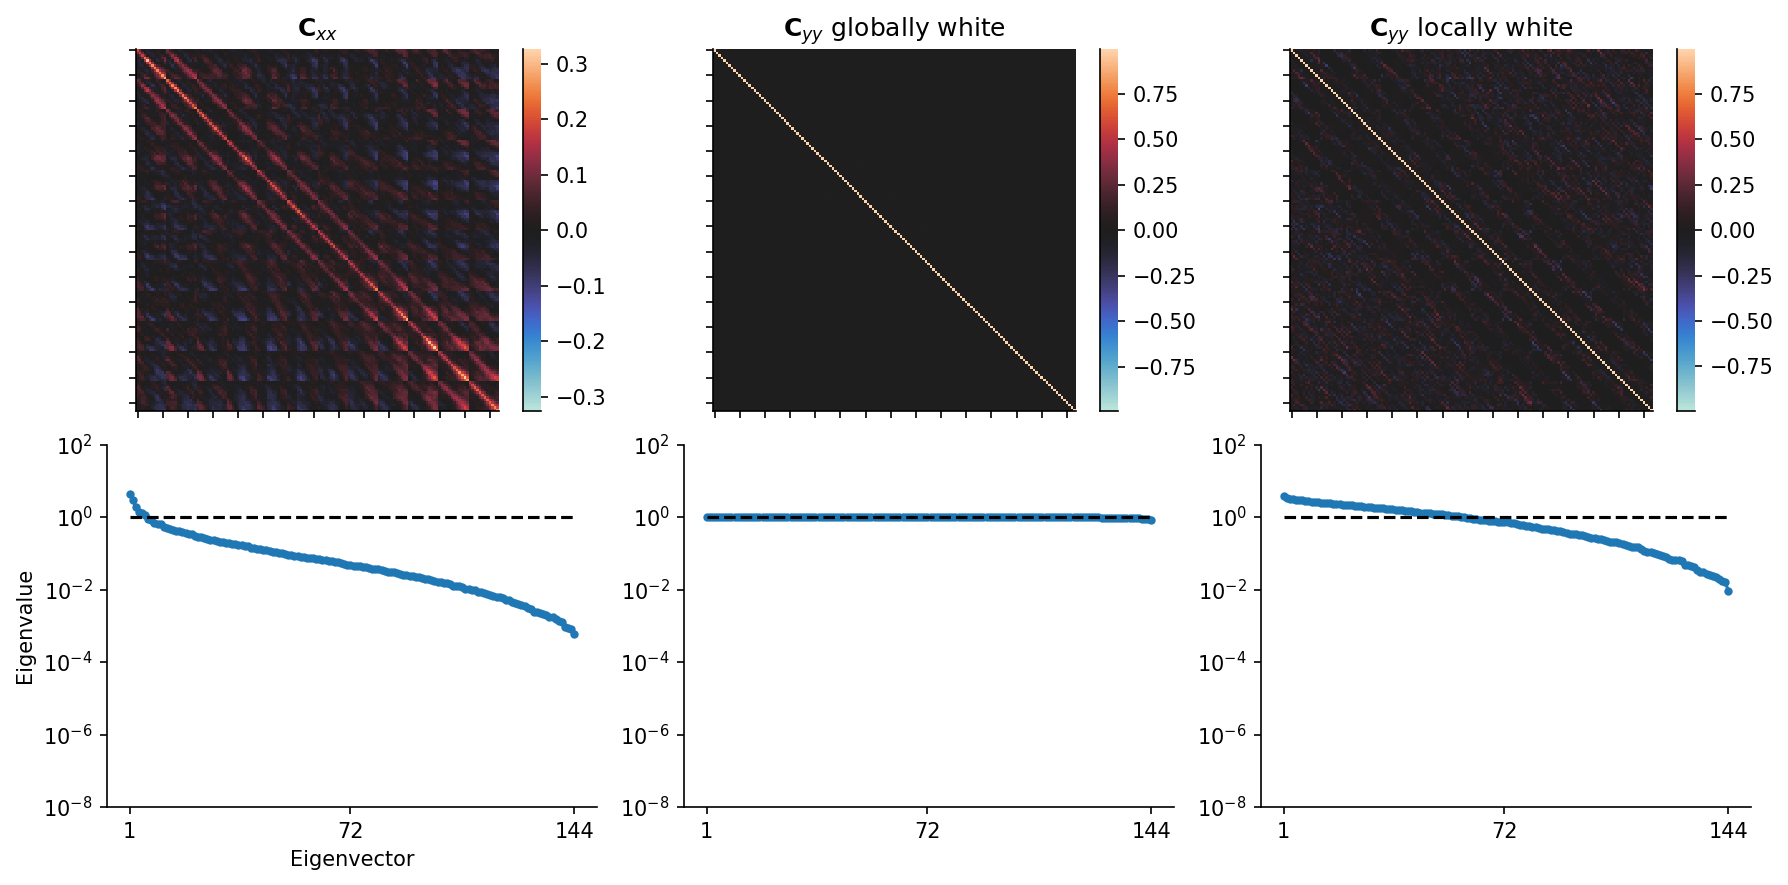

In [10]:
Cw_local = np.cov(Xw_local.reshape(n_steps, -1).T)
# Cw_clamp = np.cov(Xw_clamp.reshape(n_steps, -1).T)

ll, V = np.linalg.eigh(Cxx)
l12 = 1/np.sqrt(ll)

Mw = V @ np.diag(l12) @ V.T
Cww = Mw @ Cxx0 @ Mw.T

def heatmap(C, ax):
    _VMAX = np.max(np.abs(C)) 
    im =sns.heatmap(C, ax=ax, vmin=-_VMAX, vmax=_VMAX, cmap="icefire", cbar=True, square=True)

def spectrum(C):
    return np.sort(np.abs(np.linalg.eigh(C)[0]))[::-1] + 1E-15


fig, ax = plt.subplots(2, 3, figsize=(12, 6), dpi=150, sharex="row")
N = Cxx0.shape[0]

heatmap(Cxx0, ax[0,0])
heatmap(Cww, ax[0,1])
heatmap(Cw_local, ax[0,2])
# heatmap(Cw_clamp, ax[0,3])

ax[1,0].plot(np.arange(1,N+1), spectrum(Cxx0), ".-")
ax[1,1].plot(np.arange(1, N+1), spectrum(Cww), ".-")
ax[1,2].plot(np.arange(1, N+1), spectrum(Cw_local), ".-")
# ax[1,3].plot(np.arange(1, N+1), spectrum(Cw_clamp), ".-")

ax[1,0].hlines(1, 1, N, color="k", linestyle="--")
ax[1,1].hlines(1, 1, N, color="k", linestyle="--")
ax[1,2].hlines(1, 1, N, color="k", linestyle="--")
# ax[1,3].hlines(1, 1, N, color="k", linestyle="--")


ax[0,0].set(title=r"${\bf C}_{xx}$", xticklabels=[], yticklabels=[])
ax[0,1].set(title=r"${\bf C}_{yy}$ globally white", xticklabels=[], yticklabels=[])
ax[0,2].set(title=r"${\bf C}_{yy}$ locally white", xticklabels=[], yticklabels=[])
# ax[0,3].set(title=r"${\bf C}_{yy}$ locally adapted", xticklabels=[], yticklabels=[])

yscale = "log"
_YMIN, _YMAX = 1E-8, 100
ax[1, 0].set( yscale=yscale, 
    ylabel="Eigenvalue", xlabel="Eigenvector",
    xticks=(1, N//2, N), xticklabels=(1, N//2, N), ylim=(_YMIN, _YMAX))

ax[1, 1].set( yscale=yscale, ylim=(_YMIN, _YMAX))
ax[1, 2].set( yscale=yscale, ylim=(_YMIN, _YMAX))
# ax[1, 3].set( yscale=yscale, ylim=(_YMIN, _YMAX))

fig.tight_layout()
sns.despine()

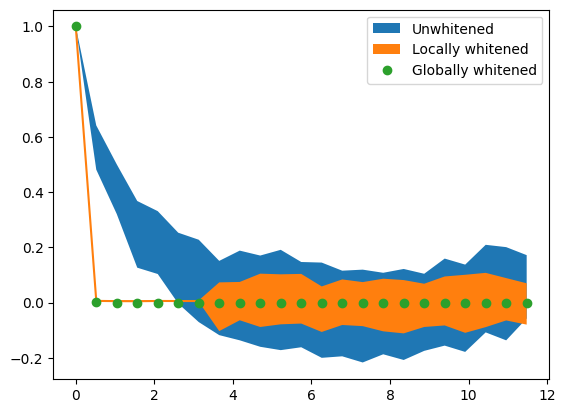

In [25]:
arr = get_corr_by_dist(X0)
yyy = scipy.stats.binned_statistic(arr[:, 0], arr[:, 1], bins=np.linspace(0, patch_h, 2*patch_h), statistic="mean")
zzz = scipy.stats.binned_statistic(arr[:, 0], arr[:, 1], bins=np.linspace(0, patch_h, 2*patch_h), statistic="std")
# plt.errorbar(yyy.bin_edges[:-1], yyy.statistic, zzz.statistic, label="Unwhitened")
mu, sig = yyy.statistic, zzz.statistic
plt.fill_between(yyy.bin_edges[:-1], mu - sig, mu + sig, label="Unwhitened")



arr = get_corr_by_dist(Xw_local.reshape(n_steps, -1))
yyy = scipy.stats.binned_statistic(arr[:, 0], arr[:, 1], bins=np.linspace(0, patch_h, 2*patch_h), statistic="mean")
zzz = scipy.stats.binned_statistic(arr[:, 0], arr[:, 1], bins=np.linspace(0, patch_h, 2*patch_h), statistic="std")
# plt.errorbar(yyy.bin_edges[:-1], yyy.statistic, zzz.statistic, label="Locally whitened")
mu, sig = yyy.statistic, zzz.statistic
plt.fill_between(yyy.bin_edges[:-1], mu - sig, mu + sig, label="Locally whitened")
plt.plot(yyy.bin_edges[:-1], yyy.statistic, "C1")


arr = get_corr_by_dist(Xw.reshape(n_steps, -1))
yyy = scipy.stats.binned_statistic(arr[:, 0], arr[:, 1], bins=np.linspace(0, patch_h, 2*patch_h), statistic="mean")
# yyy = scipy.stats.binned_statistic(arr[:, 0], arr[:, 1], bins=np.linspace(0, patch_h, 2*patch_h), statistic="mean")
plt.plot(yyy.bin_edges[:-1], yyy.statistic, "oC2", label="Globally whitened", lw=.5)

# plt.fill_between(yyy.bin_edges[:-1], mu - sig, mu + sig, label="Unwhitened")

plt.legend()